# Health data sharing is caring

This notebook was presented at MozFest 2019, for the session "Health data sharing is caring", by Natalia Norori and Stefano Vrizzi. It shows some machine learning application on a publicly available dataset on skin cancer. The aim is to highlight how accuracy scores in classication can vary according to the variability included in the training data.

As our first step, we need to import some useful libraries for our analysis.

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.io import imread_collection
from matplotlib import gridspec
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
import glob
import imageio
from sklearn.cluster import KMeans
import pylab as pl

The dataset (https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign) comprises 2D images of moles, which can be labelled as benign or malignant. Let us first have a look at one image.

### Example

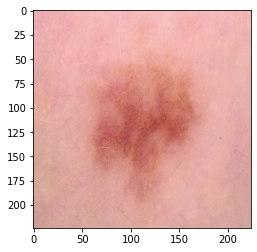

In [2]:
img=mpimg.imread('benign/23.jpg')
imgplot = plt.imshow(img)

So what is an image like this for a computer? Each image in this dataset is, essentially, a bunch of numbers. How many?

### Size of image

In [3]:
np.shape(img)

(224, 224, 3)

Each image has $224 \times 224$ pixels, with three colours (RGB), therefore each image is decribed in $224*224*3=150528$ dimensions.

From here, we want to look at the skin colour in each image. We need to define a skin patch, for instance of $10 \times 10$ pixels, close to the upper-right corner of the image (this means $10*10*3=300$ dimesions). Let us see an example from the image above. 

### Example of skin patch

In [4]:
rgb = 3

w_h = 10 #n of pixels vertically for skin patch
w_v = 10 #n of pixels horizontally for skin patch

pxl_h = 10 #row pixel number
pxl_v = 214 #column pixel number

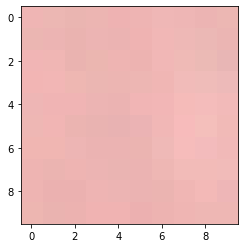

In [5]:
plt.imshow(img[pxl_h:pxl_h+w_h, pxl_v:pxl_v+w_v,:])
plt.show()

For now, we can notice that the colour may vary slightly across the pixels.

Let us now load all the data available (at first from the benign-labelled moles only, just as an example), to extract a skin patch from each image.

## Load data

In [6]:
clr = [] #skin color
benign = [] #collect skin patch colour
patch_matrix = [] #useful matrix for plotting purposes

for image_path in glob.glob('benign/*.jpg'):
    patch = imageio.imread(image_path)[pxl_h:pxl_h+w_h, pxl_v:pxl_v+w_v,:]
    patch_matrix.append(patch) #fill out list with patches

In order to better plot our images, we may want to know how many of them we loaded.

### How many images?

In [7]:
tot_fig = len(patch_matrix)
print (tot_fig)

660


Now, we want to see the skin colours we extracted from the images, sorting them from the lightest to the darkest skin patch colour.

### Sort them for plotting, according to darkness (scale)

In [8]:
scale = np.zeros((tot_fig)) #collect a value on a "darkness" scale for each skin patch

for i in range(0, tot_fig):
    scale[i] = patch_matrix[i].mean() #compute mean "darkness" of each patch
    
idx = np.argsort(scale)[::-1] #create indexing to plot skin patches according to darkness scale

Let us plot the skin patches!

### Plot skin patches

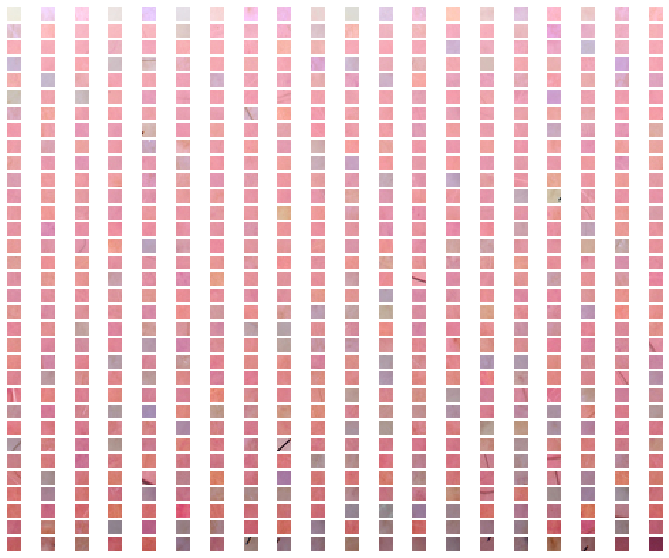

In [9]:
plt.figure(figsize=(12,10)) #create a figure

for j, ID in enumerate(idx): #plot according to darkness index
    ax = plt.subplot(33, 20, j+1) #create a subplot for each skin patch
    ax.imshow(patch_matrix[ID]) #show the skin patch
    ax.axis('off')
       
plt.show()

Now we want to import all the data, including the malignant moles.

To do this, we might want to define a easy way to extract a mean colour from the skin patches and assign the diagnosis, for any folder of images we have. There you go:

In [10]:
clr = [] #list to collect skin patch colour

#function to perform import skin patches, compute their mean colour and assign diagnosis
def patch_clr(images, diagnosis):
    
    folder = [] #list to collect skin patch pixel colour from benign/malignant moles
    
    for image_path in glob.glob(images): #read all images in the desired folder
        patch = imageio.imread(image_path)[pxl_h:pxl_h+w_h, pxl_v:pxl_v+w_v,:] #extract the 10 x 10 skin patch
        patch_reshape = np.reshape(patch, (w_h*w_v*rgb)).tolist() #put pixel colours in a list for practical reasons
        folder.append(patch_reshape) #collect skin patch pixel colour
        
        #take *mean* colour (mean RGB colours) for each skin patch across its 100 pixels
        clr.append(np.reshape(patch, (w_h*w_v, rgb)).mean(axis=0))
    
    # Add a 0 to indicate that they are from benign moles (0 = No disease), 1 from malignant moles (1 = skin cancer)
    for f in folder:
        f.append(diagnosis)
        
    return folder, clr

Now we can import the skin patches, compute their mean colour and assign the diagnosis very easily.

### Import all data and create data table

In [11]:
benign, _ = patch_clr('benign/*.jpg', diagnosis=0) #load all images in the 'benign' moles folder
benign2, _ = patch_clr('benign2/*.jpg', 0) #load all images in the 'benign2' moles folder
malignant, clr = patch_clr('malignant/*.jpg', diagnosis=1) #load all images in the 'malignant' folder

Put together the skin patches from the three folders, to create a "dataframe", that is a useful table or structure to analyse our data. Dimensions from 0 to 299 will be the pixel number. Dimension 300 will be the presence or absence of skin cancer.

In [12]:
data = benign + benign2 + malignant
df = pd.DataFrame(data)
df.rename({300: 'Disease'}, axis=1, inplace=True)

This how the upper part of our data table looks like

In [13]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Disease
0,219,160,164,217,161,164,217,160,166,220,...,216,160,173,211,156,162,212,157,162,0
1,217,129,143,209,127,141,214,127,143,214,...,208,124,139,206,124,138,209,122,139,0
2,203,131,143,199,126,137,203,130,141,198,...,198,122,134,201,131,142,205,142,153,0
3,150,100,103,150,100,109,149,99,108,148,...,152,102,114,154,104,116,155,105,116,0
4,241,174,192,239,172,190,233,169,185,239,...,233,169,185,234,172,187,235,172,189,0


As a quick example, we choose the colours of the 100 skin patch pixels as the features through which we will classify whether the mole was benign or malignant.

In [14]:
features = [i for i in df.columns[0:-2]]

## Plot variability of skin colour with diagnosis

Since every each skin patch is represented in 300 dimensions, we want to scale down to 2 only, so that we can see how the colour varies on a 2D plot. Here some linear algebra does it magic trick.

In [15]:
X = df.loc[:, features].values #from our data table, we look only at the pixel colours, i.e. our features

pca = PCA(n_components=2) #Principal Component Analysis, scaling down from 300 to 2 dimensions
PC = pca.fit_transform(X) #Transform our data for plotting
df['PC1'] = pd.Series(PC[:,0]) #Define the new 1st dimension
df['PC2'] = pd.Series(PC[:,1]) #Define the new 2nd dimension

Let us now plot the colour of each skin patch in a 2D plot.

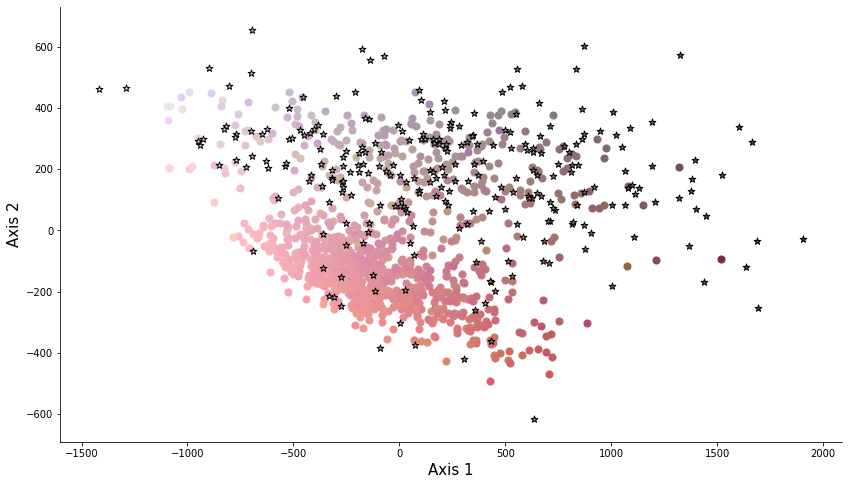

In [16]:
fig = plt.figure(figsize = (14,8)) #create figure
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Axis 1', fontsize = 15)
ax.set_ylabel('Axis 2', fontsize = 15)

#Each RGB value ranges from 0 to 255, where 0 essentially means dark and 0 very bright:
#e.g. [0, 0 , 0] is black, [255, 255, 255] is white, [255, 0, 0] is full red, etc...).
#Here, we need to rescale the value between 0 and 1, for plotting purposes
for i in df.index:
    cl = [i/255 for i in clr[i]]
    cl = np.reshape(cl, (1,3))
    
    #plot a circle for skin patches from benign moles
    if df.loc[i, 'Disease'] == 0:
        ax.scatter(df.loc[i, 'PC1'], df.loc[i, 'PC2'], c = cl, s = 50, marker='o')
    
    #plot a star for skin patches from malignant moles
    elif df.loc[i, 'Disease'] == 1:
        ax.scatter(df.loc[i, 'PC1'], df.loc[i, 'PC2'], c = cl, s = 50, marker='*', edgecolor='k')
    
ax.spines['right'].set_visible(False) #remove upper and right axes
ax.spines['top'].set_visible(False)
plt.show()

Circle is for skin patches from benign (healthy) moles; the star is for skin patches from malignant moles (skin cancer). We observe that the largest group of patches is pink-like, at the bottom-left, and it contains only few cases that were diagnosed with skin cancer. The large majority of the malignant moles extends over the other skin colours.

So, how can we capture the mean skin colour from the main group at the bottom of our graph? We can use some meachine learning, more specifically, unsupervised learning.

### Capture the main mean skin color, using unsupervised learning

Let us work in the 2D plot we just created

In [17]:
Z = np.zeros((len(data), 2))
Z[:,0] = df['PC1'].values
Z[:,1] = df['PC2'].values

Now, we group up the points into groups according to their colours. We choose to group them into 4 groups. We can choose a different number of groups, but, in this case, four turns out to be an appropriate number.

In [18]:
groups = 4
kmeans = KMeans(n_clusters=groups, random_state=0).fit(Z)

Our unsupervised learning is done. Now, let us plot the center of each group together with the data points on the 2D plane.

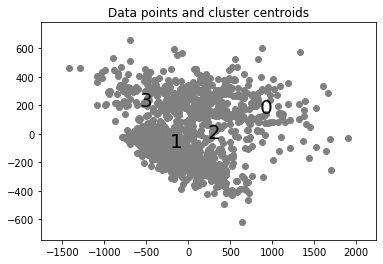

In [19]:
plt.scatter(Z[:, 0], Z[:, 1], color=[.5, .5, .5])

x = kmeans.cluster_centers_[:, 0]
y = kmeans.cluster_centers_[:, 1]

for i in range(groups):
    pl.text(x[i], y[i], str(i), color="k", fontsize=20)
pl.margins(0.1)

plt.title('Data points and cluster centroids')
plt.show()

To verify, we can look at the coordinates of the group centers on the 2D plane.

In [20]:
kmeans.cluster_centers_

array([[ 852.79124666,  145.66591936],
       [-215.54352126,  -90.49326165],
       [ 230.14606275,  -33.70952798],
       [-578.97798408,  194.65024853]])

Let us take the centre of the main group, inputting the group number seen in the plot above

In [21]:
centre = kmeans.cluster_centers_[1]

Now we can: 1) compute the distance of the skin colour of each patch, from that centre; 2) add this distance as a variable on our data table.

In [22]:
dist = np.sqrt ( (centre[0]- Z[:,0])**2 + (centre[1]- Z[:,1])**2 )
df['dist'] = pd.Series(dist)

Now we can ask ourselves how good we can be, on average, to guess the diagnosis of a mole, from a skin patch colour. To do this, we will use machine learning, more specifically some classification algorithm, with supervised learning.

### Classification of diagnosis from skin colour, using supervised learning

At first, we need to choose our classifier. As an example we use a simple neural network, called multilayer perceptro (MLP).

In [23]:
clf = MLPClassifier(alpha=1, max_iter=1000)

Our input variable $X$ will be the pixel colours from the skin patch; the desired output $y$ will be the diagnosis.

In [24]:
X = df.loc[:, features].values
y = df['Disease']

We divide our dataset in training data and test data, so that we can make the algorithm learn the association between skin colour and diagnosis, and then we can test how well it learnt the association. More specifically, we train the algorithm on $\frac{2}{3}$ of the dataset and we test on the remaining $\frac{1}{3}$.

In [25]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.3, random_state=42)

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

For one training and one test, the accuracy score, in percentage, is:

In [26]:
print (round(score*100,1), '%')

80.7 %


But we may have been just lucky. Let us run a few more tests, with a more sophisticated procedure (K-fold).

### Take average accuracy

In [27]:
score_def = []

for i in range(20):

    score = []

    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    kf.get_n_splits(X)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        score.append(clf.score(X_test, y_test))
        
    score_def.append(np.mean(score))

The mean accuracy would be

In [28]:
print (round(np.mean(score_def)*100,1), '%')

78.9 %


Now, instead, we want to see how the accuracy score changes, if we train our algorithm with skin patches that are very common in our data set (i.e. very "pink", form the main group). And then, how would it change if we also include more and more diversity in skin colour, including also patches that are more distant?

To do this, we first need to sort our data by distance from the center of the main group.

### Sort by skin colour (distance from main skin colour)

In [29]:
df = df.sort_values(by=['dist'])

Done! Now we test the accuracy score again.

In [30]:
#In order to include an increasing variability of skin colour for training,
#we will use an increasing percentage of our sorted dataset
perc = np.arange(0.1, 1, 0.05)

#We re-define our input and output, for our classification
X = df.iloc[:, features]
y = df['Disease']

#We perform the K-fold again
kfold = range(0,20)
score = np.zeros((len(perc), len(kfold)))

for p_idx, p in enumerate(perc):
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=1-p, shuffle=False)
    
    for k in kfold:
        clf.fit(X_train, y_train)
        score[p_idx, k] = clf.score(X_test, y_test)

Now we want to compare the accuracy scores, depending on the percentage of sorted dataset, used for the training.

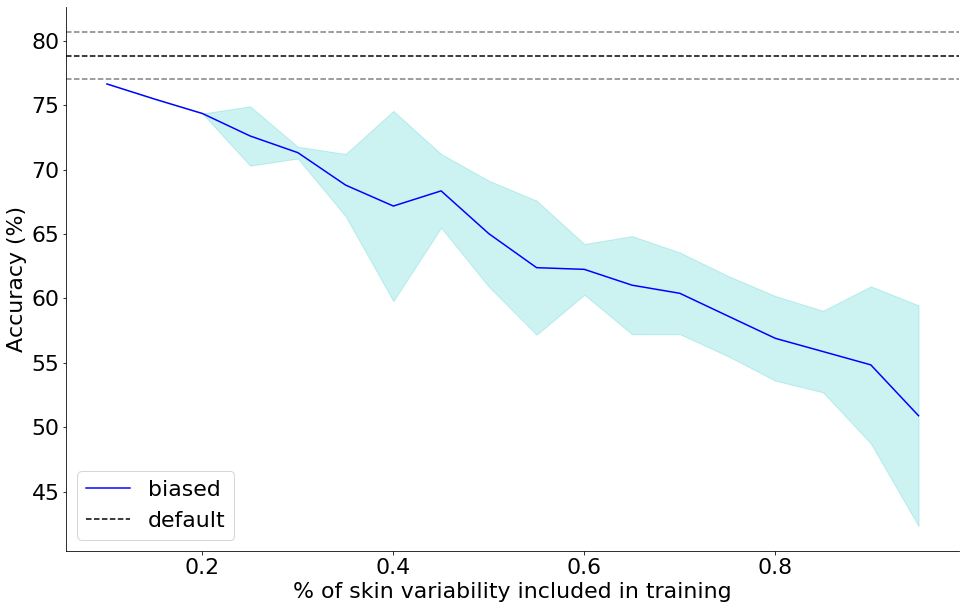

In [31]:
Y = score.mean(axis=1)*100
error = score.std(axis=1)*100
score_d = np.array(score_def)

plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1,1,1)
plt.plot(perc, Y, color='b', label='biased')
plt.fill_between(perc, Y-error, Y+error, alpha=0.2, edgecolor='c', facecolor='c')
plt.axhline(y=score_d.mean()*100, color='k', linestyle='--', label='default')
plt.axhline(y=score_d.mean()*100+score_d.std()*100, color=[.5, .5, .5], linestyle='--')
plt.axhline(y=score_d.mean()*100-score_d.std()*100, color=[.5, .5, .5], linestyle='--')
plt.xlabel('% of skin variability included in training')
plt.ylabel('Accuracy (%)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()

We have two main lines: black and blue.

The black one is the average accuracy (as seen in [28]), with the $\pm$ SD in grey. We see that, in general, we can diagnose an healthy or unhealthy skin about 8 out of 10 times.

The blue line represents the accuracy score as more and more diverse skin colour is included into the training set. In this case, we started from using only skin patches close to center of the main group, to then include skin patches that are further away. In other words, we use only "very pink" skin on the left side of axis, while we use the whole data set on the right side of axis. We achieve the same result in accuracy only when we use "very pink" skin. As we include more variability, the score drops.

This occurs because the "very pink" patches are almost all healthy (i.e. there is great imbalance in the data set). If we train the algorithm with a few "very pink" patches (which are also, in large majority, healthy), there are still many test data samples that are pink and healthy, so the algorithm learns that it can do well just by guessing that the test skin patch is healthy. However, as other skin patches are included in the training dataset, the noiser the association becomes. The algorithm knows that "very pink" very often corresponds to healthy, but it struggles with other skin colours. The more variability we feed as training to the algorithm, the messier the classification.

This analysis was just a quick example of how we can explore a dataset and apply some maching learning. Many aspects can be improved, to run a thorough proper analysis. Yet, we can highlight that

# VARIABILITY MATTERS!

We need to be careful about variability within a dataset, and how we handle it when creating diagnostic tools.